<a href="https://colab.research.google.com/github/swilsonmfc/timeseries/blob/master/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA

# Install

In [29]:
!pip install pmdarima
!pip install beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Setup

In [57]:
import warnings
warnings.filterwarnings('ignore')

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.statespace.tools import diff

from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import meanabs
from statsmodels.tools.eval_measures import aic

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima import auto_arima

from pylab import rcParams
rcParams['figure.figsize'] = 12,8

# Data
* http://nuforc.org/webreports/ndxevent.html
* Read in using requests & scrape with BeautifulSoup
* Drop old values & unusable values
* Create data frame and resample to monthly

## Scrape

In [31]:
URL = 'http://www.nuforc.org/webreports/ndxevent.html'
html_content = requests.get(URL).text
soup = BeautifulSoup(html_content, 'html.parser')

In [32]:
results = []
table = soup.find('table')
for row in table.find_all('tr', attrs={'valign':'TOP'}):
    td = row.find_all('td')
    result = {'Date':td[0].text, 'Seen':td[1].text}
    results.append(result)

## Clean

In [33]:
df = pd.DataFrame(results)
df = df[:-12] # Drop Really Old
df['Seen'] = df['Seen'].astype(int) #Integer
df.tail()

,Date,Seen
947,04/1897,2
948,06/1896,1
949,10/1886,1
950,12/1880,1
951,06/1871,1


In [34]:
df.index = pd.DatetimeIndex(pd.to_datetime(df.Date, format='%m/%Y', errors='ignore'))
df = df.drop(columns='Date')
df = df.sort_index().asfreq('MS')
df = df.fillna(0)

## Inspect

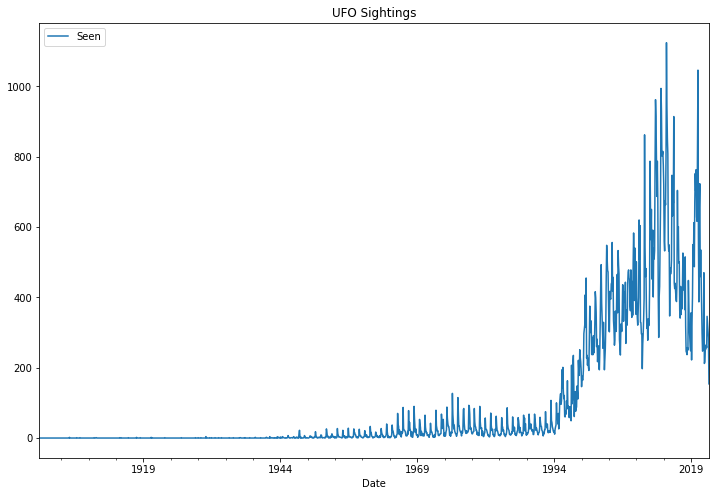

In [35]:
df = df['1900-01-01':]
df.plot(figsize=(12,8), title='UFO Sightings')

## Filter

In [36]:
df = df['2005-03-01':'2020-01-01']

# ARIMA
* Describes a process with three terms:
  * Auto Regressive - Current Value is a weighted sum of past values
  * Integrated - Differencing
  * Moving average - White noise or shocks to a system gradually reduced with time
* ARIMA models described with 3 values:
  * ARIMA(p, d, q)
  * p = number of auto regressive terms
  * d = number of differences
  * q = number of moving average terms
* Intuition
  * Linear models need stationarity (i.e. remove auto correlation)
  * To achieve stationarity we take a difference of the series itself
  * Taking differences removes the trend - I Term
  * Sometimes we over difference and need to add back - MA term
  * Sometimes differencing doesn't go far enough - AR term
* Approaches to Determining ARIMA order:
  * Heuristic using ACF and PACF plots
  * Grid search with loss (AIC)
  * Automated Search with Pyramid (AutoARIMA)

# Stationarity
* Stationarity is an assumption built into many of the techniques used for time series
* It simply means there is constant mean (no trend) and constant variance
* There are statistical tests like Augmented Dickey Fuller which test for stationarity

## Augmented Dickey-Fuller Test
* Tests for the presence of a unit root
* A unit root is a stochastic trend (random walk with drift)
* If a series has a unit root, it shows a systematic, unpredictable pattern

In [37]:
adfuller(df['Seen'])

(-1.8837615812663047,
 0.339738309092589,
 13,
 165,
 {'1%': -3.470616369591229,
  '10%': -2.57619681359045,
  '5%': -2.8792214018977655},
 2000.3191753109384)

## Wrapped

In [38]:
def stationarity_test(values, critical = 0.05):
    results = adfuller(values)
    print(f'Augmented Dickey-Fuller Statistic {results[0]}')
    print(f'  p-value {results[1]}')
    print(f'  Lags used {results[2]}')
    print(f'  Number observations {results[3]}')
    if results[1] < critical:
        print('Strong evidence to reject no unit roots')
        print('There is stationarity')
    else:
        print('Weak evidence to reject no unit roots')
        print('There is not stationarity')

In [39]:
stationarity_test(df['Seen'])

Augmented Dickey-Fuller Statistic -1.8837615812663047
  p-value 0.339738309092589
  Lags used 13
  Number observations 165
Weak evidence to reject no unit roots
There is not stationarity


# Integrated - Differencing
* To make a time series stationary, we need to change it
* We can transform it (with Box Cox -- square, exponentiate, log)
* More customarily, we difference the sequence to make it stationary
* Differencing is the change between two consecutive data points in the series
* When we diff we lose a data point!!!

## Auto Correlation
* Our dataset exhibits strong auto correlation

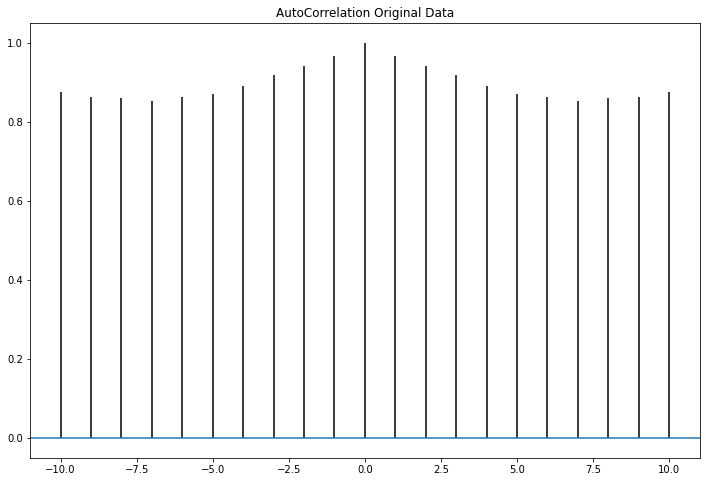

In [40]:
plt.figure(figsize=(12,8))
plt.acorr(df['Seen'])
plt.title('AutoCorrelation Original Data');

## Differencing Operator
* We'll use the diff operator in statsmodels
* Compute the first and second degree differences

In [41]:
df['Diff-1'] = diff(df)
df['Diff-2'] = diff(df['Diff-1'])
df.head()

,Seen,Diff-1,Diff-2
Date,,,
2005-03-01,361.0,NaN,NaN
2005-04-01,320.0,-41.0,NaN
2005-05-01,303.0,-17.0,24.0
2005-06-01,415.0,112.0,129.0
2005-07-01,465.0,50.0,-62.0


In [42]:
df = df.dropna()

## Differenced Plots
* The differenced data look far more
* Original Seen Data seems to have a trend up, then down
* Our differenced data appears to have been detrended

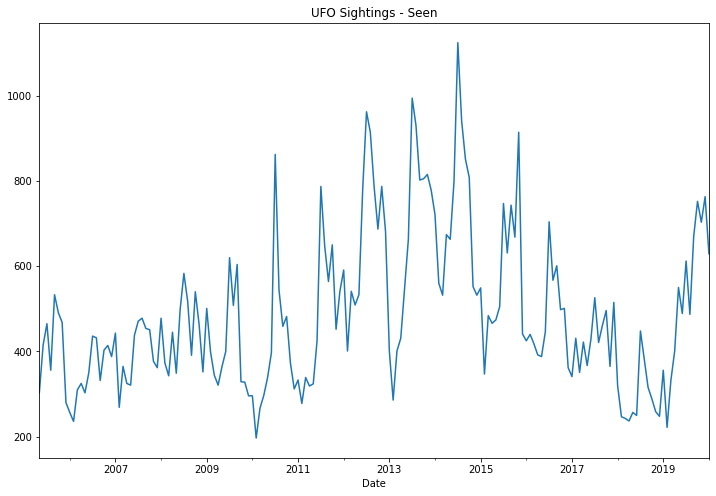

In [43]:
df['Seen'].plot(figsize=(12,8), title='UFO Sightings - Seen');

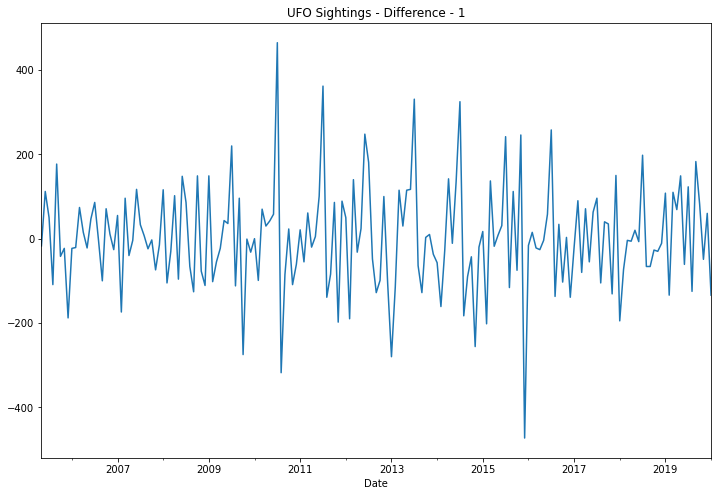

In [44]:
df['Diff-1'].plot(figsize=(12,8), title='UFO Sightings - Difference - 1')

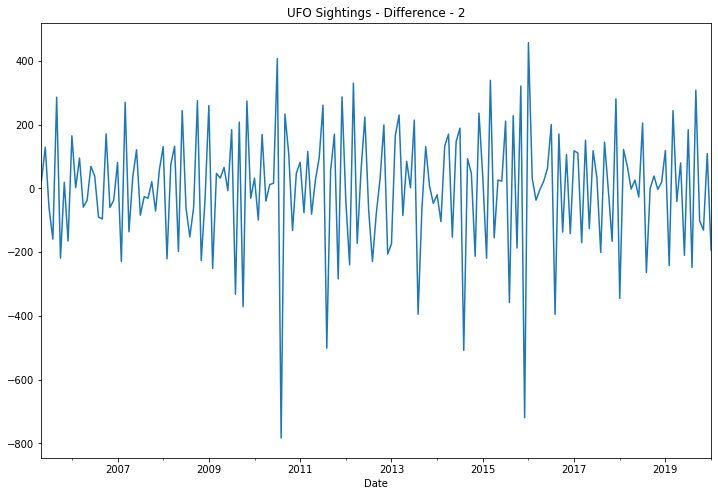

In [45]:
df['Diff-2'].plot(figsize=(12,8), title='UFO Sightings - Difference - 2')

## Stationarity Tests

In [46]:
stationarity_test(df['Seen'].dropna())

Augmented Dickey-Fuller Statistic -1.92547892848426
  p-value 0.32017156611428177
  Lags used 13
  Number observations 163
Weak evidence to reject no unit roots
There is not stationarity


In [47]:
stationarity_test(df['Diff-1'].dropna())

Augmented Dickey-Fuller Statistic -3.581187914246978
  p-value 0.006131028162216444
  Lags used 12
  Number observations 164
Strong evidence to reject no unit roots
There is stationarity


In [48]:
stationarity_test(df['Diff-2'].dropna())

Augmented Dickey-Fuller Statistic -8.75366856082342
  p-value 2.7925438604489563e-14
  Lags used 13
  Number observations 163
Strong evidence to reject no unit roots
There is stationarity


## Auto Correlation Plot
* Data is perfectly correlated with itself at timestep t
* Data is slightly negatively correlated one timestep t-1
* Original data shows large autocorrelation - Take a difference & Check

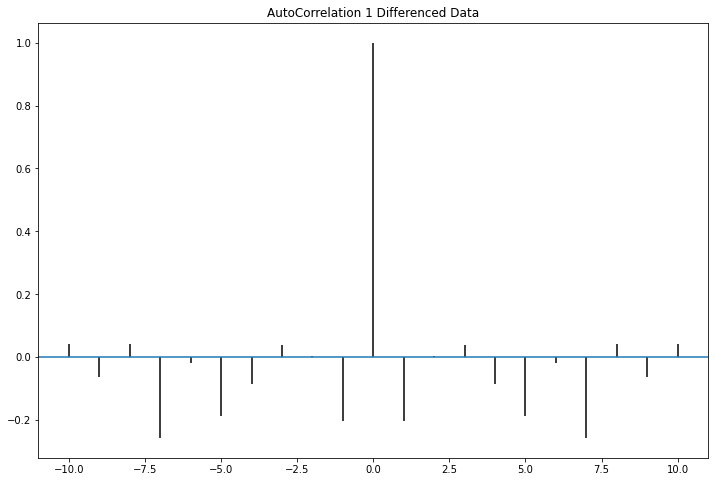

In [49]:
plt.figure(figsize=(12,8))
plt.acorr(df['Diff-1']);
plt.title('AutoCorrelation 1 Differenced Data');

# Moving Average - ACF Plot
* Moving Average - ACF Plot
* Related to acorr plot (right hand-side)
* Stands for auto correlation function
* Also called a correlogram
* Shows serial correlation in the dataset
* Significance are indicated outside of shaded region
* MA Pattern
  * Sharp cutoff
  * Lag 1 autocorrelation is negative
  * Series appears slightly over differenced
  * The lag at the ACF cutoff (of significance) indicates the number of terms
* This plot
  * Lag 0 is at 1.0 (perfect correlation)
  * Lag 1 is negative and significant
  * Pattern indicates MA term of 1
  * Lag 12 significant - may indicate yearly seasonality

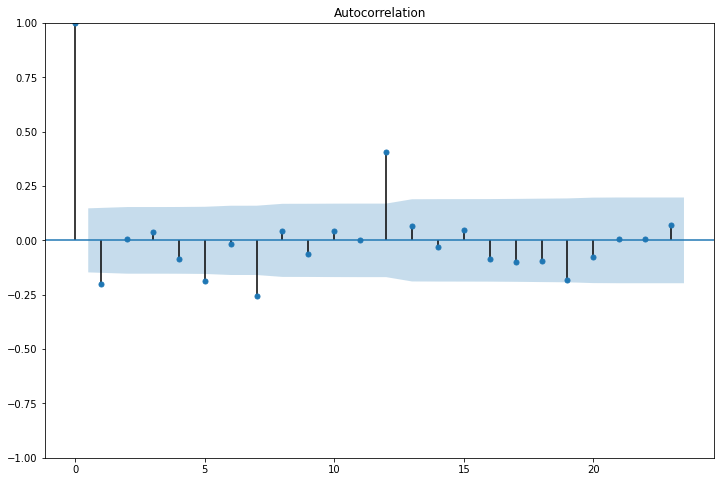

In [50]:
plot_acf(df['Diff-1']);

# Auto Regressive - PACF Plot
* PACF = Partial Auto Correlation Function Plot
* Measures the amount of correlation with each lag not accounted for by more recent lags
* For example PACF for Lag 0 and Lag 2 would measure the correlation between each while factoring out Lag 1
* AR Pattern
  * Steep dropoff
  * Lag 1 positive
  * Series appears slightly under differenced
* This plot
  * Steep dropoff
  * Negative Lag 1
  * Pattern doesn't indicate an AR term

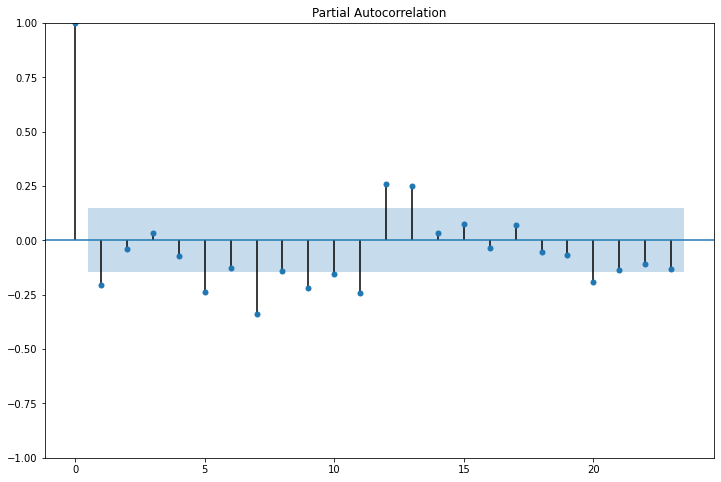

In [51]:
plot_pacf(df['Diff-1']);

# Experiment
* Heuristics
* AutoARIMA
* AutoARIMA with Seasonality

In [52]:
results_df = pd.DataFrame(columns=['RMSE', 'MAPE'])

## Train - Test

In [53]:
size = len(df)

In [54]:
train = df.iloc[:size-12]
test  = df.iloc[size-12:]

# Heuristic Model
* http://people.duke.edu/~rnau/411arim.htm
* AR = 0 No strong AR pattern present
* I = 1 We found 1 difference as sufficient to acheive stationarity
* MA = 1 Found MA pattern in data
* Order (0, 1, 1)
* There appears to be a little seasonality in the data but we're stationary

## Model

In [58]:
model = ARIMA(train['Seen'], order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Seen   No. Observations:                  165
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1022.882
Date:                Wed, 25 May 2022   AIC                           2049.764
Time:                        16:14:34   BIC                           2055.964
Sample:                    05-01-2005   HQIC                          2052.281
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2021      0.068     -2.963      0.003      -0.336      -0.068
sigma2      1.531e+04   1179.308     12.978      0.000     1.3e+04    1.76e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                39.83
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                             0.50
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predict

In [59]:
start = len(train)
end   = len(train) + len(test) - 1
preds = results.predict(start=start, end=end, typ='levels').rename('Predicted')
preds

2019-02-01    334.9411
2019-03-01    334.9411
2019-04-01    334.9411
2019-05-01    334.9411
2019-06-01    334.9411
2019-07-01    334.9411
2019-08-01    334.9411
2019-09-01    334.9411
2019-10-01    334.9411
2019-11-01    334.9411
2019-12-01    334.9411
2020-01-01    334.9411
Freq: MS, Name: Predicted, dtype: float64

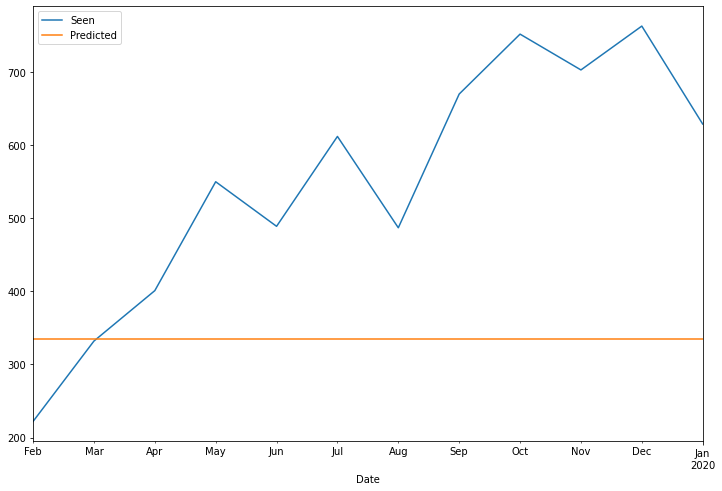

In [60]:
test['Seen'].plot(legend=True, figsize=(12,8))
preds.plot(legend=True);

## Errors

In [61]:
error = rmse(test['Seen'], preds)
print(f'RMSE = {error:.3f}')

RMSE = 270.551


In [62]:
mape = error * 100.0 / test['Seen'].mean()
print(f'MAPE = {mape:.3f}%')

MAPE = 49.117%


In [63]:
results_df.loc['Heuristic'] = [error, mape]

# Pyramid Auto-ARIMA

## AIC
* Akaike Information Criteria
* AIC = -2 (Log Likelihood) + 2K
  * K is the number of parameters in the model
  * Larger K = More Complex
  * Log-Likelihood is measure of model fit
  * Larger Log-Likelihood = Better Fit
* AIC penalizes a complex model
* All things equal, lower AIC is preferred
* BIC (Bayesian Information Criteria = More Penalty)

## Best

In [83]:
auto_arima(train['Seen'], start_p=0, start_q=0, max_p=3, max_q=3, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2056.093, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2052.174, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2051.764, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2054.094, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2039.062, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2055.497, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2055.669, Time=1.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2053.678, Time=0.63 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2053.681, Time=0.68 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2037.064, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2049.764, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2050.171, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2053.497, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

## Model

In [68]:
model = ARIMA(train['Seen'], order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Seen   No. Observations:                  165
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1015.532
Date:                Wed, 25 May 2022   AIC                           2037.064
Time:                        16:18:16   BIC                           2046.363
Sample:                    05-01-2005   HQIC                          2040.839
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6337      0.088      7.168      0.000       0.460       0.807
ma.L1         -0.9222      0.048    -19.337      0.000      -1.016      -0.829
sigma2      1.394e+04   1028.331     13.557      0.000    1.19e+04     1.6e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                59.15
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             0.73
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predict

In [69]:
start = len(train)
end   = len(train) + len(test) - 1
preds = results.predict(start=start, end=end, typ='levels').rename('Predicted')
preds

2019-02-01    357.829203
2019-03-01    358.988314
2019-04-01    359.722809
2019-05-01    360.188236
2019-06-01    360.483164
2019-07-01    360.670051
2019-08-01    360.788475
2019-09-01    360.863517
2019-10-01    360.911069
2019-11-01    360.941202
2019-12-01    360.960296
2020-01-01    360.972395
Freq: MS, Name: Predicted, dtype: float64

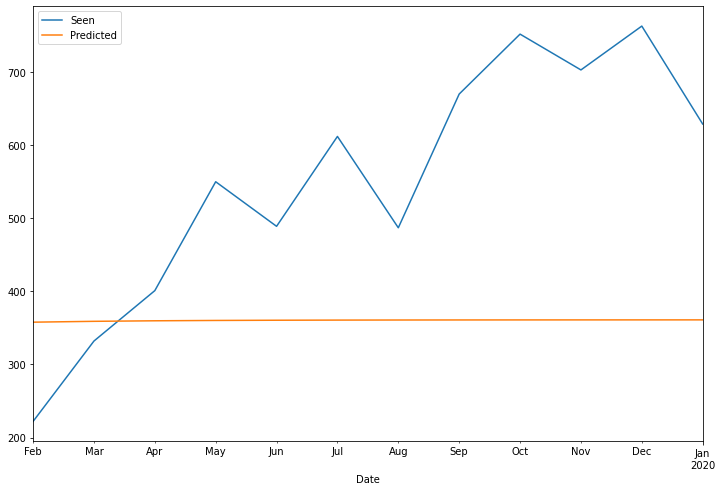

In [70]:
test['Seen'].plot(legend=True, figsize=(12,8))
preds.plot(legend=True);

## Errors

In [71]:
error = rmse(test['Seen'], preds)
print(f'RMSE = {error:.3f}')

RMSE = 250.253


In [72]:
mape = error * 100.0 / test['Seen'].mean()
print(f'MAPE = {mape:.3f}%')

MAPE = 45.432%


In [73]:
results_df.loc['ARIMA'] = [error, mape]

# SARIMAX
* Note: Our best model here was a ARIMA(0,1,1)x(1,0,1,12)
* It mirrored our heuristic based approach (0,1,1)
* WIth added seasonality annually (1,0,1,12)

## Best

In [74]:
fit_seasonal = auto_arima(train['Seen'], start_p=0, start_q=0, max_p=3, max_q=3, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2007.623, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2056.093, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2008.566, Time=0.68 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2023.079, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2054.094, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2033.523, Time=0.39 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2025.744, Time=0.31 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=6.65 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=3.10 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=2033.339, Time=1.26 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=2021.808, Time=1.01 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.80 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1988.194, Time=1.89 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2024.873, Time=0.48 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept

## Model

In [76]:
model = SARIMAX(train['Seen'], order=(1,1,1), seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Seen   No. Observations:                  165
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -984.447
Date:                            Wed, 25 May 2022   AIC                           1978.893
Time:                                    16:22:01   BIC                           1994.392
Sample:                                05-01-2005   HQIC                          1985.185
                                     - 01-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3890      0.078      4.997      0.000       0.236       0.542
ma.L1         -0.8277      0.063    -13.040      0.000      -0.952      -0.703
ar.S.L12       0.9217      0.070     13.150      0.000       0.784       1.059
ma.S.L12      -0.6562      0.135     -4.861      0.000      -0.921      -0.392
sigma2      9142.8954    817.698     11.181      0.000    7540.237    1.07e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                50.34
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.84   Skew:                             0.38
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predict

In [77]:
start = len(train)
end   = len(train) + len(test) - 1
preds = results.predict(start=start, end=end, typ='levels').rename('Predicted')
preds

2019-02-01    249.794546
2019-03-01    222.145117
2019-04-01    225.483926
2019-05-01    221.169444
2019-06-01    256.742995
2019-07-01    414.949226
2019-08-01    336.460251
2019-09-01    324.951167
2019-10-01    302.733893
2019-11-01    276.270413
2019-12-01    243.309279
2020-01-01    229.352910
Freq: MS, Name: Predicted, dtype: float64

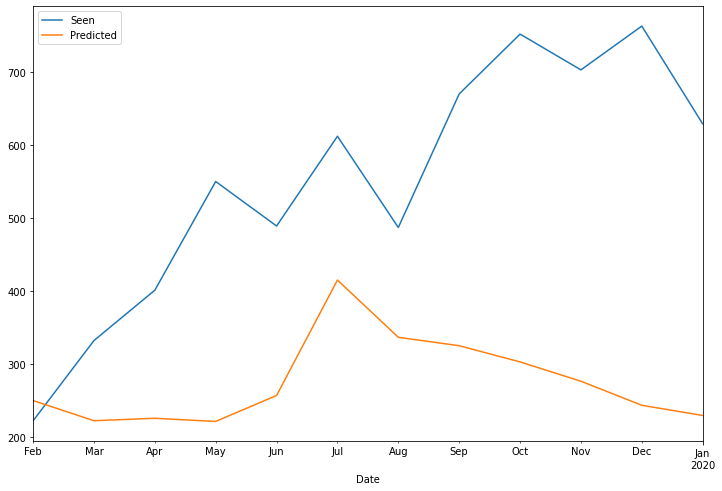

In [78]:
test['Seen'].plot(legend=True, figsize=(12,8))
preds.plot(legend=True);

## Errors

In [79]:
error = rmse(test['Seen'], preds)
print(f'RMSE = {error:.3f}')

RMSE = 316.228


In [80]:
mape = error * 100.0 / test['Seen'].mean()
print(f'MAPE = {mape:.3f}%')

MAPE = 57.409%


In [81]:
results_df.loc['SARIMAX'] = [error, mape]

# Comparison

In [82]:
results_df

,RMSE,MAPE
Heuristic,270.550541,49.116588
ARIMA,250.252836,45.431680
SARIMAX,316.228255,57.409063


# ARIMA and ETS
* There common patterns and explanations around ARIMA and ETS
* For many ETS models there is an ARIMA analog (converse is not true)

## ETS(A,N,N)
* A = Type of Model (Additive, Multiplicative)
* N = Trend Component (None, Additive, Multiplicative, Automatic)
* N = Seasonal Component (None, Additive, Multiplicative, Automatic)

## ARIMA(q,d,p)
* ARIMA (0,0,0) = White Noise
* ARIMA (0,1,0) = Random Walk
* ARIMA (0,1,0) + Constant = Random Walk + Drift
* ARIMA (1,0,0) + Constant = Regress Y on Lag Y(1)
* ARIMA (1,1,0) + Constant = Regress Y Diff(1) on Lag Y Diff(1)
* ARIMA (0,1,1) = Simple Exponential Smoothing
* ARIMA (0,2,2) = Holt Winters

## Model Choice
* Help deciding between ARIMA and ETS
  * Plot Data & Look for Trend & Seasonality --> ETS
  * Evidence of Autocorrelation --> ARIMA
  * Exogenous variables --> ARIMA
  * Compare techniques
* ARIMA(0,2,2) and Holt-Winters are equvalent
  * The UK Centre for the Measurement of Government Activity (UKCeMGA) Study
  * Question - Should they switch from ETS to ARIMA?
  * Tests
    * Multiple series
    * One step ahead prediction accuracy (MAE, MAPE)
    * ETS forecasts in ARIMA prediction interval
  * The paper concludes "...ultimately there is little difference in predictive performance between the Holt-Winters and ARIMA methods when producing one-step-ahead forecasts of components of quarterly estimates of public service output."
  * http://www.ons.gov.uk/ons/guide-method/ukcemga/publications-home/publications/archive/from-holt-winters-to-arima-modelling--measuring-the-impact-on-forecasting-errors-for-components-of-quarterly-estimates-of-public-service-output.pdf